<a href="https://colab.research.google.com/github/ktgiahieu/BinPickingSimulation/blob/master/experiments/predict_impact/%5Bwhole_paper%5D_train_logimpact_2018_deberta_v3_large_%7C_P_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization
## Check the current environment

In [5]:
!pip install -q git+https://github.com/huggingface/peft

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.3 MB/s eta 0:00:00


In [6]:
!pip install -q datasets evaluate transformers sentencepiece cpm_kernels iterative-stratification==0.1.7 accelerate jiwer bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
root_data_dir = None
ENVIRONMENT = None
api_key_dir = None

if 'google.colab' in str(get_ipython()):
    print("Running on Colab")
    from google.colab import drive
    drive.mount('/content/gdrive')

    root_data_dir = '/content/gdrive/MyDrive/UPSaclay/LLMs/semantic_scholar'
    ENVIRONMENT = 'colab'
    api_key_dir = '/content/gdrive/MyDrive/UPSaclay'
    
elif 'kaggle' in os.environ.get('KAGGLE_URL_BASE', ''):
    print("Running on Kaggle")
    root_data_dir = '/kaggle/input/semantic-scholar-metadata'
    ENVIRONMENT = 'kaggle'
else:
    print("Running locally using Github repo")
    root_data_dir = './semantic_scholar'
    ENVIRONMENT = 'local'
    api_key_dir = '.'

Running on Colab
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Modelling
## User's config

In [56]:
# ====================================================
# CFG
# ====================================================
OUTPUT_DIR = "./"
class CFG:
    wandb=False
    wandb_project_name = 'ReAIgen_predict_impact'
    debug=False
    apex=True
    print_freq=20
    num_workers=0
    wandb_project_subname="ptuning_logimpact2018"
    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=10
    encoder_lr=2e-4
    decoder_lr=2e-4
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=1
    max_len=3072
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    input_csv_filename = 'semantic_scholar.csv'
    target_cols=['log_citationCount'] #citationCount, influentialCitationCount
    seed=42
    n_fold=4
    trn_fold=[0] #add more
    train=True
    model_name_or_path = "microsoft/deberta-v3-large"
    fbprize_peft_model_name_or_path = f"ktgiahieu/{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
    fbprize_base_model_name_or_path = f"ktgiahieu/base-{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
    task = "mrpc"
    
if CFG.debug:
    CFG.epochs = 3
    CFG.trn_fold = [0]

In [57]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    import json
    try:
        if ENVIRONMENT == 'kaggle':
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            with open(os.path.join(api_key_dir, 'wandb_api_key,json'), 'r') as f:
                secret_value_0 = json.load(f)['key']
        
        os.environ['WANDB_API_KEY'] = secret_value_0
        wandb.login(key=secret_value_0, relogin=True)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project=CFG.wandb_project_name, 
                     name=CFG.model + '_' + CFG.wandb_project_subname,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [58]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

!pip install -q lifelines
from scipy.stats import kendalltau
from lifelines.utils import concordance_index

os.system('pip install iterative-stratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftConfig,
    PeftModel
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizers.__version__: 0.13.3
transformers.__version__: 4.30.1
env: TOKENIZERS_PARALLELISM=true


In [59]:
# ====================================================
# Utils
# ====================================================
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

PADDED_Y_VALUE = -1

def ndcg(y_pred, y_true, ats=None, gain_function=lambda x: torch.pow(2, x) - 1, padding_indicator=PADDED_Y_VALUE,
         filler_value=1.0):
    """
    Normalized Discounted Cumulative Gain at k.

    Compute NDCG at ranks given by ats or at the maximum rank if ats is None.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param ats: optional list of ranks for NDCG evaluation, if None, maximum rank is used
    :param gain_function: callable, gain function for the ground truth labels, e.g. torch.pow(2, x) - 1
    :param padding_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :param filler_value: a filler NDCG value to use when there are no relevant items in listing
    :return: NDCG values for each slate and rank passed, shape [batch_size, len(ats)]
    """
    idcg = dcg(y_true, y_true, ats, gain_function, padding_indicator)
    ndcg_ = dcg(y_pred, y_true, ats, gain_function, padding_indicator) / idcg
    idcg_mask = idcg == 0
    ndcg_[idcg_mask] = filler_value  # if idcg == 0 , set ndcg to filler_value

    assert (ndcg_ < 0.0).sum() >= 0, "every ndcg should be non-negative"

    return ndcg_


def __apply_mask_and_get_true_sorted_by_preds(y_pred, y_true, padding_indicator=PADDED_Y_VALUE):
    mask = y_true == padding_indicator

    y_pred[mask] = float('-inf')
    y_true[mask] = 0.0

    _, indices = y_pred.sort(descending=True, dim=-1)
    return torch.gather(y_true, dim=1, index=indices)


def dcg(y_pred, y_true, ats=None, gain_function=lambda x: torch.pow(2, x) - 1, padding_indicator=PADDED_Y_VALUE):
    """
    Discounted Cumulative Gain at k.

    Compute DCG at ranks given by ats or at the maximum rank if ats is None.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param ats: optional list of ranks for DCG evaluation, if None, maximum rank is used
    :param gain_function: callable, gain function for the ground truth labels, e.g. torch.pow(2, x) - 1
    :param padding_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: DCG values for each slate and evaluation position, shape [batch_size, len(ats)]
    """
    y_true = y_true.clone()
    y_pred = y_pred.clone()

    actual_length = y_true.shape[1]

    if ats is None:
        ats = [actual_length]
    ats = [min(at, actual_length) for at in ats]

    true_sorted_by_preds = __apply_mask_and_get_true_sorted_by_preds(y_pred, y_true, padding_indicator)

    discounts = (torch.tensor(1) / torch.log2(torch.arange(true_sorted_by_preds.shape[1], dtype=torch.float) + 2.0)).to(
        device=true_sorted_by_preds.device)

    gains = gain_function(true_sorted_by_preds)

    discounted_gains = (gains * discounts)[:, :np.max(ats)]

    cum_dcg = torch.cumsum(discounted_gains, dim=1)

    ats_tensor = torch.tensor(ats, dtype=torch.long) - torch.tensor(1)

    dcg = cum_dcg[:, ats_tensor]

    return dcg


def mrr(y_pred, y_true, ats=None, padding_indicator=PADDED_Y_VALUE):
    """
    Mean Reciprocal Rank at k.

    Compute MRR at ranks given by ats or at the maximum rank if ats is None.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param ats: optional list of ranks for MRR evaluation, if None, maximum rank is used
    :param padding_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: MRR values for each slate and evaluation position, shape [batch_size, len(ats)]
    """
    y_true = y_true.clone()
    y_pred = y_pred.clone()

    if ats is None:
        ats = [y_true.shape[1]]

    true_sorted_by_preds = __apply_mask_and_get_true_sorted_by_preds(y_pred, y_true, padding_indicator)

    values, indices = torch.max(true_sorted_by_preds, dim=1)
    indices = indices.type_as(values).unsqueeze(dim=0).t().expand(len(y_true), len(ats))

    ats_rep = torch.tensor(data=ats, device=indices.device, dtype=torch.float32).expand(len(y_true), len(ats))

    within_at_mask = (indices < ats_rep).type(torch.float32)

    result = torch.tensor(1.0) / (indices + torch.tensor(1.0))

    zero_sum_mask = torch.sum(values) == 0.0
    result[zero_sum_mask] = 0.0

    result = result * within_at_mask

    return result


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [55]:
# ====================================================
# Data Loading
# ====================================================
def get_full_text(row):
    with open(f"/content/gdrive/MyDrive/UPSaclay/LLMs/semantic_scholar/parsed_data/{row['pdf_name']}/pdf/{row['pdf_name']}.json", 'r') as f:
        return f.read()
train = pd.read_csv(os.path.join(root_data_dir, CFG.input_csv_filename))
train = train[train['year']==2018].reset_index(drop=True)
train['text'] = train.apply(get_full_text, axis=1)
train['log_citationCount'] = train['citationCount'].apply(lambda x: np.log(x+1))

print(f"train.shape: {train.shape}")
display(train.head())

train.shape: (591, 16)


,semantic_scholar_id,title,abstract,year,authors,citationCount,citationStyles,openAccessPdf,publicationVenue,publicationTypes,s2FieldsOfStudy,influentialCitationCount,pdf_name,topic,text,log_citationCount
0,44cbf4240b017e997a6b3a478798e53f2b50761c,The Brisbane Declaration and Global Action Age...,"A decade ago, scientists and practitioners wor...",2018,"A. Arthington, A. Bhaduri, S. Bunn, S. Jackson...",231,"{'bibtex': ""@['Review']{Arthington2018TheBD,\n...",https://www.frontiersin.org/articles/10.3389/f...,"{'id': 'c0ded351-0e49-473e-816e-23b84c9f8dd3',...",Review,Environmental Science,11,environmental_science16,environmental_science,"{\n ""authors"": ""Sergi Sabater; Gilles Pinay...",5.446737
1,925ece7359af59ae033028e436545fd56279e84b,A Critical Time for Mercury Science to Inform ...,Mercury is a global pollutant released into th...,2018,"Celia Y. Chen, C. Driscoll, C. Eagles‐Smith, C...",72,"{'bibtex': ""@['JournalArticle']{Chen2018ACT,\n...",https://dspace.mit.edu/bitstream/1721.1/123488...,"{'id': '9efb20cf-7484-450d-8245-12dfbf639d3e',...",JournalArticle,"Environmental Science, Medicine, Political Sci...",2,environmental_science41,environmental_science,"{\n ""authors"": ""Celia Y Chen; Charles Drisc...",4.290459
2,ed89a76714e4e46c5d3fc48b892baca42efe5b3b,The discontinuity of environmental effects mon...,"Long-term regional environmental monitoring, c...",2018,"Joshua G. Cronmiller, B. Noble",19,"{'bibtex': ""@['Review']{Cronmiller2018TheDO,\n...",https://tspace.library.utoronto.ca/bitstream/1...,"{'id': '2115dc5e-9318-4ae7-b64c-0948fd079390',...",Review,"Environmental Science, Environmental Science",1,environmental_science48,environmental_science,"{\n ""authors"": ""Joshua G Cronmiller"",\n ...",2.995732
3,5ceabacfa0939f948e395d1c99d988bf37c6dd44,Renewable Sources of Plant Biostimulation: Mic...,Plant biostimulants (PBs) attract interest in ...,2018,"Pasquale Chiaiese, G. Corrado, G. Colla, M. Ky...",136,"{'bibtex': ""@['Review', 'JournalArticle']{Chia...",https://www.frontiersin.org/articles/10.3389/f...,"{'id': 'e110cc75-cd00-4b7f-968c-fd70b464a553',...","Review, JournalArticle","Environmental Science, Medicine, Engineering",5,environmental_science101,environmental_science,"{\n ""authors"": ""Antonio Ferrante; Alexandro...",4.919981
4,cfaa5db0ba59ba0fe628ef858db50995acc9d6e7,Detection and Quantification of Graphene-Famil...,An increase in production of commercial produc...,2018,"D. Goodwin, A. Adeleye, L. Sung, K. Ho, R. Bur...",120,"{'bibtex': ""@['JournalArticle', 'Review']{Good...",https://europepmc.org/articles/pmc5940015?pdf=...,"{'id': '9efb20cf-7484-450d-8245-12dfbf639d3e',...","JournalArticle, Review","Environmental Science, Medicine, Environmental...",0,environmental_science105,environmental_science,"{\n ""authors"": ""David G Goodwin; Adeyemi S ...",4.795791


In [ ]:
train.to_csv('/content/gdrive/MyDrive/UPSaclay/LLMs/semantic_scholar/full_text_semantic_scholar.csv', index=False)

fold
0    148
1    148
2    148
3    147
dtype: int64

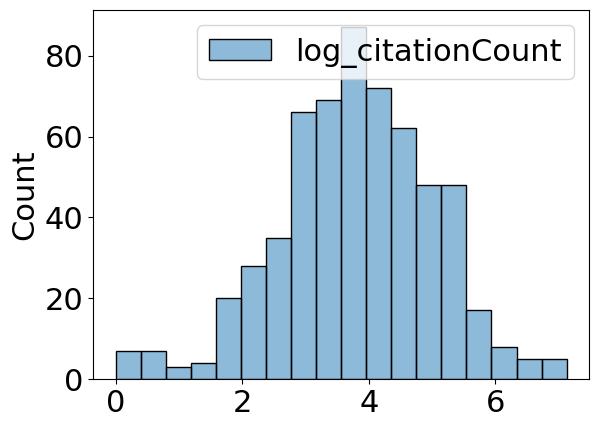

In [60]:
# ====================================================
# CV split
# ====================================================
if len(CFG.target_cols) >= 2:
    Fold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols])):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)
else:
    train['grp'] = pd.cut(train[CFG.target_cols[0]], 10, labels=False)
    Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    train['fold']=-1
    for n, (train_index, val_index) in enumerate(Fold.split(train['grp'], train['grp'])):
        train.loc[val_index, 'fold'] = int(n)      
    train['fold'] = train['fold'].astype(int)
    
# train = train.groupby('fold').sample(n=100, random_state=0).reset_index(drop=True)
display(train.groupby('fold').size())

# Histogram of the target value
sns.histplot(train[CFG.target_cols])
plt.show()

In [61]:
if CFG.debug:
    train = train.groupby('fold').sample(n=3, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

In [62]:
# ===== Tokenizers ===== 

if any(k in CFG.model_name_or_path for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/591 [00:00<?, ?it/s]

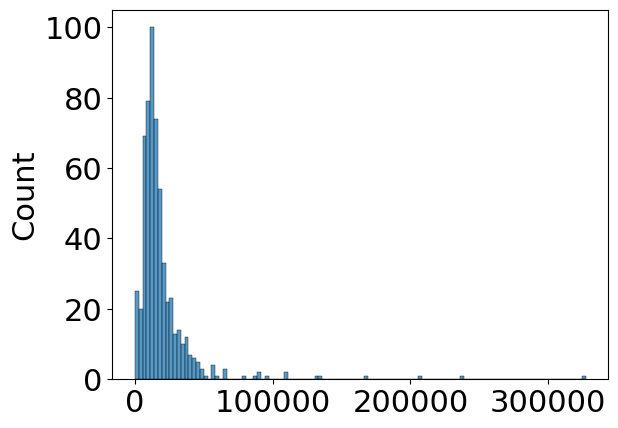

maximum sequence length: 327347
maximum sequence length: 327347
maximum sequence length: 327347
INFO:__main__:maximum sequence length: 327347


In [63]:
# ====================================================
# Define max_len
# ====================================================
lengths = []
tk0 = tqdm(train['text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
# CFG.max_len = max(lengths) + 3 # cls & sep & sep

sns.histplot(lengths)
plt.show()
LOGGER.info(f"maximum sequence length: {max(lengths) + 3}")

In [64]:
print("Number of samples:")
print(np.array(lengths).shape[0])
print(f"Number of samples with token length > {CFG.max_len}:")
print((np.array(lengths) > CFG.max_len).sum())
print(f"Percentage of samples with token length > {CFG.max_len}:")
print((np.array(lengths) > CFG.max_len).sum()*100/np.array(lengths).shape[0], '%')

Number of samples:
591
Number of samples with token length > 3072:
563
Percentage of samples with token length > 3072:
95.26226734348562 %


Because there is little to no samples that exceeds the current `max_len`, we will use the current `max_len`

In [65]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

## Model, metrics and loss

In [66]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel(self.config)




        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, len(CFG.target_cols))
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

In [67]:
# ====================================================
# Evaluation metric
# ====================================================
class QuadraticKappaMetric(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = torch.tensor(weights)

    def get_score(self, y_trues, y_preds):
        print(y_trues.shape, y_preds.shape, self.weights.shape)
        if len(y_trues.shape)==1 or y_trues.shape[1]==1:
            return quadratic_weighted_kappa(y_trues.reshape(-1), y_preds.reshape(-1))
        else:
            assert self.weights.shape[0] == y_trues.shape[1]
            score = 0
            for i, w in enumerate(self.weights):
                score += w * quadratic_weighted_kappa(y_trues[:,i], y_preds[:,i])
            return score
    
    def is_left_score_better(self, left_score, right_score):
        return left_score > right_score
    
class KendallTauMetric(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = torch.tensor(weights)

    def get_score(self, y_trues, y_preds):
        if len(y_trues.shape)==1 or y_trues.shape[1]==1:
            return kendalltau(y_trues.reshape(-1), y_preds.reshape(-1)).correlation
        else:
            assert self.weights.shape[0] == y_trues.shape[1]
            score = 0
            for i, w in enumerate(self.weights):
                score += w * kendalltau(y_trues[:,i], y_preds[:,i]).correlation
            return score
    
    def is_left_score_better(self, left_score, right_score):
        return left_score > right_score
    
MODEL_EVALUATION_FUNCTION = KendallTauMetric(weights=[1.0])

In [68]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9, weights = None):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps
        self.weights = torch.tensor(weights).to(device)

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'weighted':
            assert self.weights.shape[0] == loss.shape[1]
            loss = (loss * self.weights.reshape(1, self.weights.shape[0])).sum(dim=1).mean()
        return loss
    
    def is_left_score_better(self, left_score, right_score):
        return left_score > right_score
    
MODEL_LOSS_FUNCTION = RMSELoss(reduction="weighted", weights=[1.0])

In [69]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(**inputs).logits
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(**inputs).logits
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.detach().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    preds = np.concatenate(preds)
    return losses.avg, preds


In [70]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    # model = CustomModel(CFG, config_path=None, pretrained=True)
    peft_type = PeftType.P_TUNING
    peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128, inference_mode=False)
    model = AutoModelForSequenceClassification.from_pretrained(CFG.fbprize_base_model_name_or_path, return_dict=True, num_labels=len(CFG.target_cols), problem_type = "regression")
    model = get_peft_model(model, peft_config)

    # torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    # def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    #     param_optimizer = list(model.named_parameters())
    #     no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    #     optimizer_parameters = [
    #         {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
    #          'lr': encoder_lr, 'weight_decay': weight_decay},
    #         {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
    #          'lr': encoder_lr, 'weight_decay': 0.0},
    #         {'params': [p for n, p in model.named_parameters() if "model" not in n],
    #          'lr': decoder_lr, 'weight_decay': 0.0}
    #     ]
    #     return optimizer_parameters

    # optimizer_parameters = get_optimizer_params(model,
    #                                             encoder_lr=CFG.encoder_lr, 
    #                                             decoder_lr=CFG.decoder_lr,
    #                                             weight_decay=CFG.weight_decay)
    optimizer = AdamW(model.parameters(), lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = MODEL_LOSS_FUNCTION
    
    best_score = -1

    for epoch in range(CFG.epochs):

        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        # scoring
        score = MODEL_EVALUATION_FUNCTION.get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if MODEL_EVALUATION_FUNCTION.is_left_score_better(score, best_score):
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict()}, OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best.pth")
            torch.save({'predictions': predictions},  OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best_predictions.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best_predictions.pth", 
                             map_location=torch.device('cpu'))['predictions']

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, predictions

## Let's start training
All the plot and results are collected using the link below (on the `wandb.ai` server)

In [71]:
if __name__ == '__main__':
    
    def get_result(oof_df, oof_predictions):
        labels = oof_df[CFG.target_cols].values
        preds = oof_predictions
        score = MODEL_EVALUATION_FUNCTION.get_score(labels, preds)
        LOGGER.info(f'score: {score:.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        oof_predictions = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, _oof_predictions = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                oof_predictions.append(_oof_predictions)
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df, _oof_predictions)
        oof_df = oof_df.reset_index(drop=True)
        oof_predictions = np.concatenate(oof_predictions, axis=0)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df, oof_predictions)
        for target_i, target_col in enumerate(CFG.target_cols):
            oof_df['oof_pred_'+target_col] = oof_predictions[:, target_i]
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
INFO:__main__:========== fold: 0 training ==========
Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.modules_to_save.default.weight', 'classifier.original_module.bias', 'classifier.modules_to_save.default.bias', 'classifier.original_module.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some

Epoch: [1][0/443] Elapsed 0m 1s (remain 8m 2s) Loss: 4.3864(4.3864) Grad: nan  LR: 0.00020000  
Epoch: [1][20/443] Elapsed 0m 39s (remain 13m 6s) Loss: 2.8169(3.3264) Grad: 242756.4219  LR: 0.00019999  
Epoch: [1][40/443] Elapsed 1m 0s (remain 9m 57s) Loss: 1.7119(2.6351) Grad: 244537.7812  LR: 0.00019996  
Epoch: [1][60/443] Elapsed 1m 34s (remain 9m 52s) Loss: 0.2238(2.3431) Grad: 266994.6562  LR: 0.00019991  
Epoch: [1][80/443] Elapsed 1m 58s (remain 8m 49s) Loss: 0.2116(2.0276) Grad: 246116.9844  LR: 0.00019984  
Epoch: [1][100/443] Elapsed 2m 24s (remain 8m 7s) Loss: 0.8792(1.7504) Grad: 239356.9062  LR: 0.00019974  
Epoch: [1][120/443] Elapsed 2m 47s (remain 7m 24s) Loss: 2.0496(1.6479) Grad: 236250.7812  LR: 0.00019963  
Epoch: [1][140/443] Elapsed 3m 16s (remain 7m 0s) Loss: 1.8185(1.5955) Grad: 246616.2969  LR: 0.00019950  
Epoch: [1][160/443] Elapsed 3m 55s (remain 6m 52s) Loss: 0.6202(1.4995) Grad: 265474.8438  LR: 0.00019935  
Epoch: [1][180/443] Elapsed 4m 26s (remain 6m 2

Epoch 1 - avg_train_loss: 1.1329  avg_val_loss: 0.8737  time: 919s
Epoch 1 - avg_train_loss: 1.1329  avg_val_loss: 0.8737  time: 919s
Epoch 1 - avg_train_loss: 1.1329  avg_val_loss: 0.8737  time: 919s
INFO:__main__:Epoch 1 - avg_train_loss: 1.1329  avg_val_loss: 0.8737  time: 919s
Epoch 1 - score: 0.3573
Epoch 1 - score: 0.3573
Epoch 1 - score: 0.3573
INFO:__main__:Epoch 1 - score: 0.3573
Epoch 1 - Save Best Score: 0.3573 Model
Epoch 1 - Save Best Score: 0.3573 Model
Epoch 1 - Save Best Score: 0.3573 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.3573 Model


EVAL: [73/74] Elapsed 4m 59s (remain 0m 0s) Loss: 1.0731(0.8737) 
Epoch: [2][0/443] Elapsed 0m 1s (remain 7m 45s) Loss: 2.2746(2.2746) Grad: nan  LR: 0.00019508  
Epoch: [2][20/443] Elapsed 0m 47s (remain 15m 53s) Loss: 0.5062(0.9747) Grad: 15855.9746  LR: 0.00019463  
Epoch: [2][40/443] Elapsed 1m 17s (remain 12m 37s) Loss: 0.2035(0.9250) Grad: 14936.3730  LR: 0.00019417  
Epoch: [2][60/443] Elapsed 1m 42s (remain 10m 42s) Loss: 0.9922(0.8913) Grad: 15570.8516  LR: 0.00019368  
Epoch: [2][80/443] Elapsed 2m 5s (remain 9m 21s) Loss: 0.6434(0.8937) Grad: 16310.9736  LR: 0.00019317  
Epoch: [2][100/443] Elapsed 2m 28s (remain 8m 23s) Loss: 0.5196(0.8877) Grad: 15097.6377  LR: 0.00019265  
Epoch: [2][120/443] Elapsed 2m 55s (remain 7m 47s) Loss: 1.1308(0.9094) Grad: 15737.3057  LR: 0.00019211  
Epoch: [2][140/443] Elapsed 3m 22s (remain 7m 14s) Loss: 1.3055(0.9040) Grad: 16207.5527  LR: 0.00019155  
Epoch: [2][160/443] Elapsed 3m 43s (remain 6m 30s) Loss: 0.5888(0.9198) Grad: 15652.8037  

Epoch 2 - avg_train_loss: 0.8832  avg_val_loss: 0.8269  time: 916s
Epoch 2 - avg_train_loss: 0.8832  avg_val_loss: 0.8269  time: 916s
Epoch 2 - avg_train_loss: 0.8832  avg_val_loss: 0.8269  time: 916s
INFO:__main__:Epoch 2 - avg_train_loss: 0.8832  avg_val_loss: 0.8269  time: 916s
Epoch 2 - score: 0.3839
Epoch 2 - score: 0.3839
Epoch 2 - score: 0.3839
INFO:__main__:Epoch 2 - score: 0.3839
Epoch 2 - Save Best Score: 0.3839 Model
Epoch 2 - Save Best Score: 0.3839 Model
Epoch 2 - Save Best Score: 0.3839 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.3839 Model


EVAL: [73/74] Elapsed 4m 57s (remain 0m 0s) Loss: 1.2174(0.8269) 
Epoch: [3][0/443] Elapsed 0m 1s (remain 8m 36s) Loss: 1.4136(1.4136) Grad: nan  LR: 0.00018086  
Epoch: [3][20/443] Elapsed 0m 36s (remain 12m 6s) Loss: 0.2918(0.6788) Grad: 115836.6562  LR: 0.00018002  
Epoch: [3][40/443] Elapsed 1m 17s (remain 12m 43s) Loss: 0.8528(0.7476) Grad: 113878.9375  LR: 0.00017916  
Epoch: [3][60/443] Elapsed 1m 41s (remain 10m 34s) Loss: 1.0874(0.8194) Grad: 127741.7344  LR: 0.00017828  
Epoch: [3][80/443] Elapsed 2m 3s (remain 9m 10s) Loss: 1.8984(0.7966) Grad: 116683.2031  LR: 0.00017739  
Epoch: [3][100/443] Elapsed 2m 30s (remain 8m 27s) Loss: 0.7876(0.7709) Grad: 115307.0078  LR: 0.00017649  
Epoch: [3][120/443] Elapsed 2m 53s (remain 7m 43s) Loss: 1.3626(0.7593) Grad: 62226.1562  LR: 0.00017557  
Epoch: [3][140/443] Elapsed 3m 16s (remain 7m 0s) Loss: 0.8218(0.7574) Grad: 58830.0859  LR: 0.00017463  
Epoch: [3][160/443] Elapsed 3m 44s (remain 6m 33s) Loss: 0.7136(0.7836) Grad: 58570.671

Epoch 3 - avg_train_loss: 0.8010  avg_val_loss: 0.7845  time: 916s
Epoch 3 - avg_train_loss: 0.8010  avg_val_loss: 0.7845  time: 916s
Epoch 3 - avg_train_loss: 0.8010  avg_val_loss: 0.7845  time: 916s
INFO:__main__:Epoch 3 - avg_train_loss: 0.8010  avg_val_loss: 0.7845  time: 916s
Epoch 3 - score: 0.4211
Epoch 3 - score: 0.4211
Epoch 3 - score: 0.4211
INFO:__main__:Epoch 3 - score: 0.4211
Epoch 3 - Save Best Score: 0.4211 Model
Epoch 3 - Save Best Score: 0.4211 Model
Epoch 3 - Save Best Score: 0.4211 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.4211 Model


EVAL: [73/74] Elapsed 4m 58s (remain 0m 0s) Loss: 1.0101(0.7845) 
Epoch: [4][0/443] Elapsed 0m 1s (remain 8m 10s) Loss: 0.0040(0.0040) Grad: nan  LR: 0.00015872  
Epoch: [4][20/443] Elapsed 0m 24s (remain 8m 12s) Loss: 1.1616(0.8861) Grad: 236605.3281  LR: 0.00015757  
Epoch: [4][40/443] Elapsed 0m 57s (remain 9m 27s) Loss: 0.4567(0.9456) Grad: 242582.7344  LR: 0.00015640  
Epoch: [4][60/443] Elapsed 1m 22s (remain 8m 34s) Loss: 1.5066(0.9048) Grad: 232912.3594  LR: 0.00015522  
Epoch: [4][80/443] Elapsed 1m 45s (remain 7m 52s) Loss: 0.7806(0.9164) Grad: 237173.1719  LR: 0.00015404  
Epoch: [4][100/443] Elapsed 2m 9s (remain 7m 18s) Loss: 0.3775(0.9216) Grad: 243259.4531  LR: 0.00015284  
Epoch: [4][120/443] Elapsed 2m 35s (remain 6m 54s) Loss: 0.6773(0.8737) Grad: 245585.0156  LR: 0.00015163  
Epoch: [4][140/443] Elapsed 2m 58s (remain 6m 21s) Loss: 0.9720(0.8302) Grad: 231876.5625  LR: 0.00015041  
Epoch: [4][160/443] Elapsed 3m 27s (remain 6m 3s) Loss: 2.0716(0.8252) Grad: 114868.03

Epoch 4 - avg_train_loss: 0.7818  avg_val_loss: 0.8048  time: 919s
Epoch 4 - avg_train_loss: 0.7818  avg_val_loss: 0.8048  time: 919s
Epoch 4 - avg_train_loss: 0.7818  avg_val_loss: 0.8048  time: 919s
INFO:__main__:Epoch 4 - avg_train_loss: 0.7818  avg_val_loss: 0.8048  time: 919s
Epoch 4 - score: 0.4132
Epoch 4 - score: 0.4132
Epoch 4 - score: 0.4132
INFO:__main__:Epoch 4 - score: 0.4132


EVAL: [73/74] Elapsed 5m 0s (remain 0m 0s) Loss: 0.9082(0.8048) 
Epoch: [5][0/443] Elapsed 0m 1s (remain 7m 45s) Loss: 0.4090(0.4090) Grad: nan  LR: 0.00013083  
Epoch: [5][20/443] Elapsed 0m 25s (remain 8m 23s) Loss: 0.2354(0.7238) Grad: 117898.1328  LR: 0.00012948  
Epoch: [5][40/443] Elapsed 0m 50s (remain 8m 12s) Loss: 0.2030(0.7025) Grad: 112491.9688  LR: 0.00012812  
Epoch: [5][60/443] Elapsed 1m 21s (remain 8m 30s) Loss: 1.1501(0.7092) Grad: 117554.0000  LR: 0.00012676  
Epoch: [5][80/443] Elapsed 2m 1s (remain 9m 3s) Loss: 0.8082(0.7295) Grad: nan  LR: 0.00012539  
Epoch: [5][100/443] Elapsed 2m 21s (remain 7m 57s) Loss: 2.9844(0.7583) Grad: 61567.9648  LR: 0.00012402  
Epoch: [5][120/443] Elapsed 2m 44s (remain 7m 18s) Loss: 0.8212(0.7500) Grad: 58207.6367  LR: 0.00012264  
Epoch: [5][140/443] Elapsed 3m 11s (remain 6m 50s) Loss: 0.2023(0.7709) Grad: 60847.8867  LR: 0.00012125  
Epoch: [5][160/443] Elapsed 3m 36s (remain 6m 19s) Loss: 0.3391(0.7541) Grad: 60352.0039  LR: 0.000

Epoch 5 - avg_train_loss: 0.7583  avg_val_loss: 0.7550  time: 918s
Epoch 5 - avg_train_loss: 0.7583  avg_val_loss: 0.7550  time: 918s
Epoch 5 - avg_train_loss: 0.7583  avg_val_loss: 0.7550  time: 918s
INFO:__main__:Epoch 5 - avg_train_loss: 0.7583  avg_val_loss: 0.7550  time: 918s
Epoch 5 - score: 0.4387
Epoch 5 - score: 0.4387
Epoch 5 - score: 0.4387
INFO:__main__:Epoch 5 - score: 0.4387
Epoch 5 - Save Best Score: 0.4387 Model
Epoch 5 - Save Best Score: 0.4387 Model
Epoch 5 - Save Best Score: 0.4387 Model
INFO:__main__:Epoch 5 - Save Best Score: 0.4387 Model


EVAL: [73/74] Elapsed 4m 58s (remain 0m 0s) Loss: 0.5595(0.7550) 
Epoch: [6][0/443] Elapsed 0m 1s (remain 7m 41s) Loss: 1.4453(1.4453) Grad: nan  LR: 0.00009993  


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:14                                                                             │
│ in train_loop:87                                                                                 │
│ in train_fn:54                                                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/_tensor.py:487 in backward                         │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200 in backward               │
│                                                                                                  │
│   197 │   # The reason we repeat same the comment below is that                                  │
│   198 │   # some Python versions print out the first line of a multi-line function               │
│   199 │   # calls in the traceback and some print out the last line                              │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   203                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

# Eval

In [81]:
# ====================================================
# eval loop
# ====================================================
def eval_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    # model = CustomModel(CFG, config_path=None, pretrained=True)
    peft_type = PeftType.P_TUNING
    peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128, inference_mode=False)
    model = AutoModelForSequenceClassification.from_pretrained(CFG.fbprize_base_model_name_or_path, return_dict=True, num_labels=len(CFG.target_cols), problem_type = "regression")
    model = get_peft_model(model, peft_config)

    model.load_state_dict(torch.load(OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device(device))['model'])

    # torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    # def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    #     param_optimizer = list(model.named_parameters())
    #     no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    #     optimizer_parameters = [
    #         {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
    #          'lr': encoder_lr, 'weight_decay': weight_decay},
    #         {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
    #          'lr': encoder_lr, 'weight_decay': 0.0},
    #         {'params': [p for n, p in model.named_parameters() if "model" not in n],
    #          'lr': decoder_lr, 'weight_decay': 0.0}
    #     ]
    #     return optimizer_parameters

    # optimizer_parameters = get_optimizer_params(model,
    #                                             encoder_lr=CFG.encoder_lr, 
    #                                             decoder_lr=CFG.decoder_lr,
    #                                             weight_decay=CFG.weight_decay)
    # optimizer = AdamW(model.parameters(), lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # # ====================================================
    # # scheduler
    # # ====================================================
    # def get_scheduler(cfg, optimizer, num_train_steps):
    #     if cfg.scheduler == 'linear':
    #         scheduler = get_linear_schedule_with_warmup(
    #             optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
    #         )
    #     elif cfg.scheduler == 'cosine':
    #         scheduler = get_cosine_schedule_with_warmup(
    #             optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
    #         )
    #     return scheduler
    
    # num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    # scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # # ====================================================
    # # loop
    # # ====================================================
    criterion = MODEL_LOSS_FUNCTION
    
    # best_score = -1


    start_time = time.time()
    
    # train
    # avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

    # eval
    avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

    # scoring
    score = MODEL_EVALUATION_FUNCTION.get_score(valid_labels, predictions)

    elapsed = time.time() - start_time

    # LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # if CFG.wandb:
    #     wandb.log({f"[fold{fold}] epoch": epoch+1, 
    #                f"[fold{fold}] avg_train_loss": avg_loss, 
    #                f"[fold{fold}] avg_val_loss": avg_val_loss,
    #                f"[fold{fold}] score": score})
    
    # if MODEL_EVALUATION_FUNCTION.is_left_score_better(score, best_score):
    #     best_score = score
    #     LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
    #     torch.save({'model': model.state_dict()}, OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best.pth")
    #     torch.save({'predictions': predictions},  OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best_predictions.pth")

    # predictions = torch.load(OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold{fold}_best_predictions.pth", 
    #                          map_location=torch.device('cpu'))['predictions']

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, predictions

In [87]:
if __name__ == '__main__':
    
    def get_result(oof_df, oof_predictions):
        labels = oof_df[CFG.target_cols].values
        preds = oof_predictions
        score = MODEL_EVALUATION_FUNCTION.get_score(labels, preds)
        LOGGER.info(f'score: {score:.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        oof_predictions = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, _oof_predictions = eval_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                oof_predictions.append(_oof_predictions)
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df, _oof_predictions)
        oof_df = oof_df.reset_index(drop=True)
        oof_predictions = np.concatenate(oof_predictions, axis=0)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df, oof_predictions)
        for target_i, target_col in enumerate(CFG.target_cols):
            oof_df['oof_pred_'+target_col] = oof_predictions[:, target_i]
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
INFO:__main__:========== fold: 0 training ==========
Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.modules_to_save.default.weight', 'classifier.original_module.bias', 'classifier.modules_to_save.default.bias', 'classifier.original_module.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some

EVAL: [0/74] Elapsed 0m 1s (remain 1m 38s) Loss: 1.4228(1.4228) 
EVAL: [20/74] Elapsed 0m 36s (remain 1m 32s) Loss: 0.5021(0.7673) 
EVAL: [40/74] Elapsed 1m 7s (remain 0m 54s) Loss: 0.5937(0.7093) 
EVAL: [60/74] Elapsed 4m 25s (remain 0m 56s) Loss: 0.9329(0.7328) 
EVAL: [73/74] Elapsed 4m 47s (remain 0m 0s) Loss: 0.5595(0.7550) 


========== fold: 0 result ==========
========== fold: 0 result ==========
========== fold: 0 result ==========
INFO:__main__:========== fold: 0 result ==========
score: 0.4387
score: 0.4387
score: 0.4387
INFO:__main__:score: 0.4387
========== CV ==========
========== CV ==========
========== CV ==========
INFO:__main__:========== CV ==========
score: 0.4387
score: 0.4387
score: 0.4387
INFO:__main__:score: 0.4387


# Push to the hub

In [85]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [82]:
peft_type = PeftType.P_TUNING
peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128, inference_mode=False)
model = AutoModelForSequenceClassification.from_pretrained(CFG.fbprize_base_model_name_or_path, return_dict=True, num_labels=len(CFG.target_cols), problem_type = "regression")
model = get_peft_model(model, peft_config)

model.load_state_dict(torch.load(OUTPUT_DIR+f"{CFG.model_name_or_path.replace('/', '-')}_fold0_best.pth", 
                             map_location=torch.device(device))['model'])

Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.modules_to_save.default.weight', 'classifier.original_module.bias', 'classifier.modules_to_save.default.bias', 'classifier.original_module.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize and are newly initi

<All keys matched successfully>

In [86]:
model.push_to_hub('ktgiahieu/deberta-v3-large-ptuning-logimpact-fullpaper', use_auth_token=True)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ktgiahieu/deberta-v3-large-ptuning-logimpact-fullpaper/commit/8024acd01629366db09c368d843f0a3d7cad9a29', commit_message='Upload model', commit_description='', oid='8024acd01629366db09c368d843f0a3d7cad9a29', pr_url=None, pr_revision=None, pr_num=None)

# Summarization on all data


## Test scores

In [88]:
# Citation counts prediction score

oof_labels = oof_df[CFG.target_cols[0]].values
oof_preds = oof_df['oof_pred_' + CFG.target_cols[0]].values

kendall_tau_score = kendalltau(oof_labels, oof_preds)
print("Kendall Tau score:\n\tCorrelation:", kendall_tau_score.correlation, "\n\tp-value:", kendall_tau_score.pvalue, '\n')

print("Concordance index:", concordance_index(oof_labels, oof_preds), "\n")

print("Quadratic Kappa score:", quadratic_weighted_kappa(oof_labels, oof_preds), "\n")

# print("NDCG score:", ndcg(torch.tensor(oof_preds.reshape(1,-1)), torch.tensor(oof_labels.reshape(1,-1))).numpy()[0][0], "\n")

Kendall Tau score:
	Correlation: 0.43867613760144547 
	p-value: 3.159922281192237e-15 

Concordance index: 0.7201185075455976 

Quadratic Kappa score: 0.5197765638477021 



## Histograms

### Marginal histogram

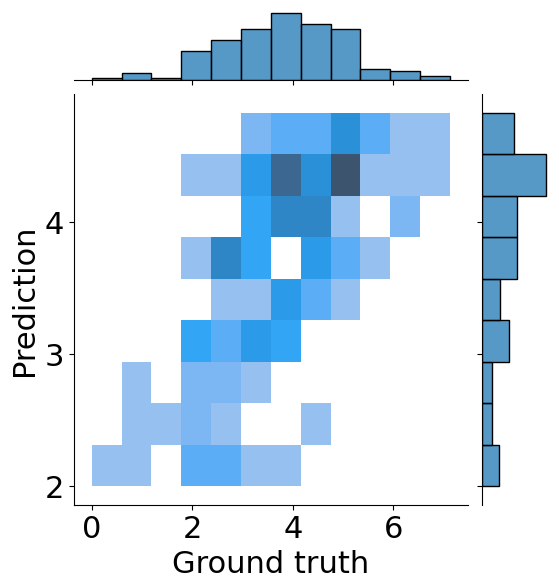

In [89]:
def marginal_histogram_plot():
    ax1 = sns.jointplot(x=oof_labels, y=oof_preds, kind="hist")
    plt.xlabel('Ground truth')
    plt.ylabel('Prediction')
marginal_histogram_plot()

### Normalized occurences

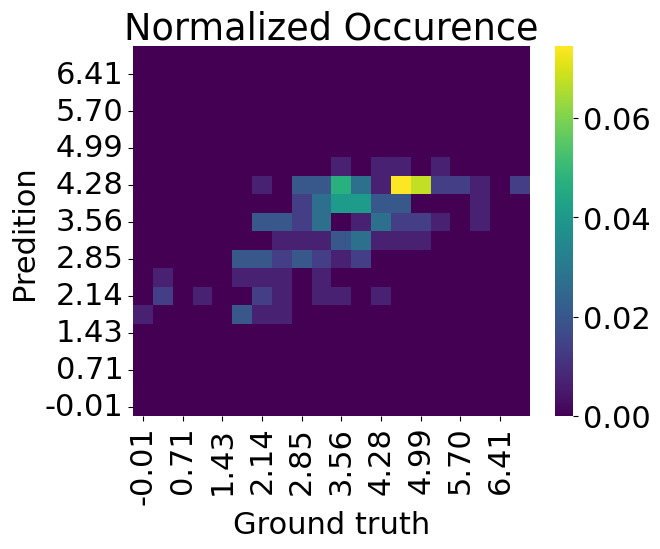

In [90]:
def normalized_occurences_plot(labels, preds, num_bins=20):
    df_plot = pd.DataFrame({'label': labels, 'pred': preds})
    # Calculation
    N = df_plot.count().iloc[0]
    
    # Cut labels and preds to bins
    df_plot['label'], retbin = pd.cut(df_plot['label'], num_bins, labels=False, retbins=True,include_lowest=False)
    df_plot['pred'] = pd.cut(df_plot['pred'], bins=retbin, labels=False).fillna(-1)
    
    heatmap = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            heatmap[i,j] = len(df_plot[(df_plot['label']==j)&(df_plot["pred"]==i)])/N
    heatmap_df = pd.DataFrame(heatmap, columns=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]])
    heatmap_df.index=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]]

    # Plot
    plt.rcParams.update({'font.size': 22})

    ax = sns.heatmap(heatmap_df, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.yticks(rotation=0) 
    ax.invert_yaxis()
    plt.title('Normalized Occurence')
    plt.ylabel('Predition')
    plt.xlabel('Ground truth')
    plt.show()
    
normalized_occurences_plot(oof_labels, oof_preds)

### Marginal product

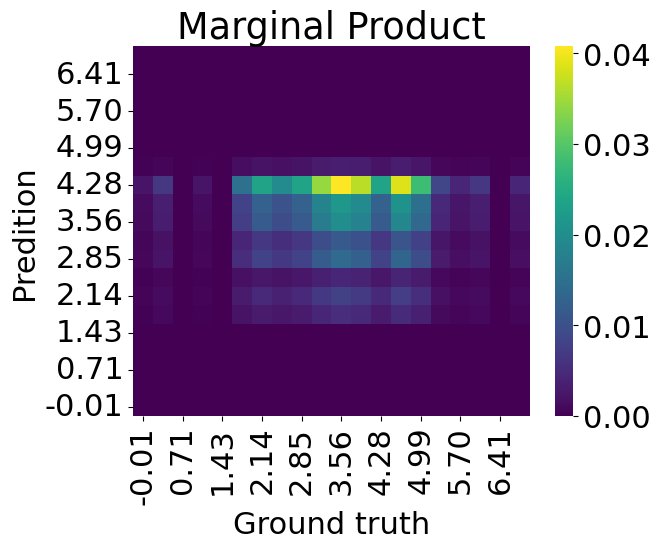

In [91]:
def marginal_product_plot(labels, preds, num_bins=20):
    df_plot = pd.DataFrame({'label': labels, 'pred': preds})
    # Calculation
    N = df_plot.count().iloc[0]
    
    # Cut labels and preds to bins
    df_plot['label'], retbin = pd.cut(df_plot['label'], num_bins, labels=False, retbins=True,include_lowest=False)
    df_plot['pred'] = pd.cut(df_plot['pred'], bins=retbin, labels=False).fillna(-1)
    
    heatmap = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            N_i = len(df_plot[(df_plot['pred']==i)])
            N_j = len(df_plot[(df_plot['label']==j)])
            
            heatmap[i,j] = N_i*N_j/N**2
    heatmap_df = pd.DataFrame(heatmap, columns=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]])
    heatmap_df.index=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]]

    # Plot
    plt.rcParams.update({'font.size': 22})

    ax = sns.heatmap(heatmap_df, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.yticks(rotation=0) 
    ax.invert_yaxis()
    plt.title('Marginal Product')
    plt.ylabel('Predition')
    plt.xlabel('Ground truth')
    plt.show()
    
marginal_product_plot(oof_labels, oof_preds)

### Normalized occurences / Marginal product

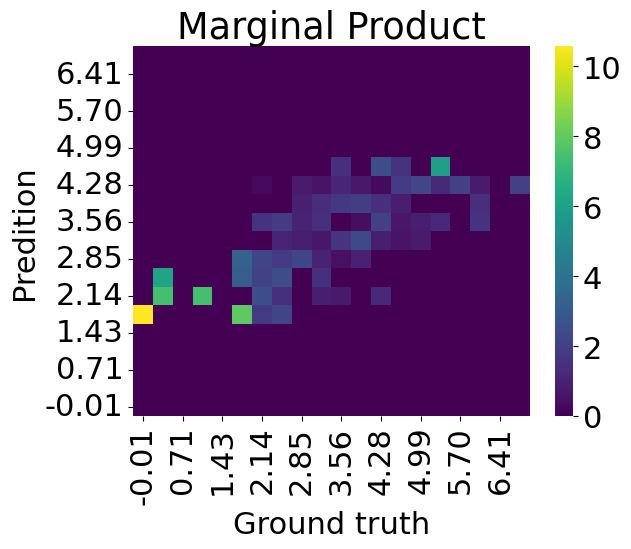

In [92]:
def marginal_product_plot(labels, preds, num_bins=20):
    df_plot = pd.DataFrame({'label': labels, 'pred': preds})
    # Calculation
    N = df_plot.count().iloc[0]
    
    # Cut labels and preds to bins
    df_plot['label'], retbin = pd.cut(df_plot['label'], num_bins, labels=False, retbins=True,include_lowest=False)
    df_plot['pred'] = pd.cut(df_plot['pred'], bins=retbin, labels=False).fillna(-1)
    
    heatmap = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            N_i = len(df_plot[(df_plot['pred']==i)])
            N_j = len(df_plot[(df_plot['label']==j)])
            N_ij = len(df_plot[(df_plot['pred']==i)&(df_plot['label']==j)])
            
            eps = 1
            heatmap[i,j] = N_ij*N / ((N_i+eps) * (N_j+eps))
    heatmap_df = pd.DataFrame(heatmap, columns=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]])
    heatmap_df.index=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]]

    # Plot
    plt.rcParams.update({'font.size': 22})

    ax = sns.heatmap(heatmap_df, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.yticks(rotation=0) 
    ax.invert_yaxis()
    plt.title('Marginal Product')
    plt.ylabel('Predition')
    plt.xlabel('Ground truth')
    plt.show()
    
marginal_product_plot(oof_labels, oof_preds)

# Summarization on top 5% citations


## Test scores

In [93]:
# Citation counts prediction score

oof_labels = oof_df[oof_df['citationCount'] > oof_df['citationCount'].quantile(0.95)][CFG.target_cols[0]].values
oof_preds = oof_df[oof_df['citationCount'] > oof_df['citationCount'].quantile(0.95)]['oof_pred_' + CFG.target_cols[0]].values

kendall_tau_score = kendalltau(oof_labels, oof_preds)
print("Kendall Tau score:\n\tCorrelation:", kendall_tau_score.correlation, "\n\tp-value:", kendall_tau_score.pvalue, '\n')

print("Concordance index:", concordance_index(oof_labels, oof_preds), "\n")

print("Quadratic Kappa score:", quadratic_weighted_kappa(oof_labels, oof_preds), "\n")

# print("NDCG score:", ndcg(torch.tensor(oof_preds.reshape(1,-1)), torch.tensor(oof_labels.reshape(1,-1))).numpy()[0][0], "\n")

Kendall Tau score:
	Correlation: 0.3571428571428571 
	p-value: 0.27509920634920637 

Concordance index: 0.6785714285714286 

Quadratic Kappa score: 0.03703703703703709 



## Histograms

### Marginal histogram

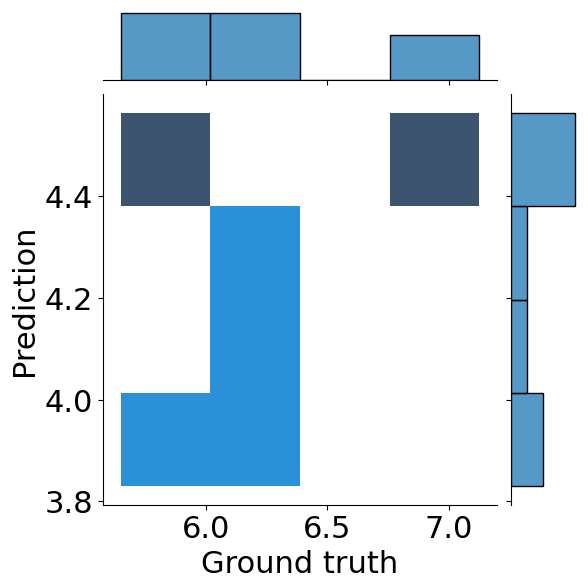

In [94]:
def marginal_histogram_plot():
    ax1 = sns.jointplot(x=oof_labels, y=oof_preds, kind="hist")
    plt.xlabel('Ground truth')
    plt.ylabel('Prediction')
marginal_histogram_plot()

### Normalized occurences

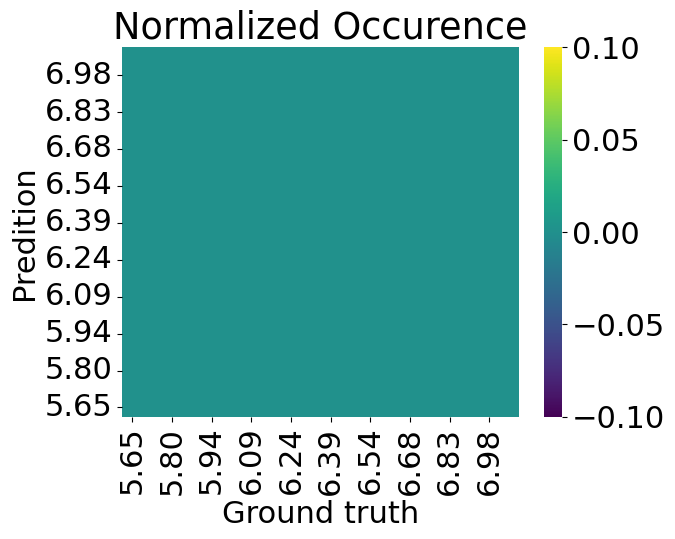

In [95]:
def normalized_occurences_plot(labels, preds, num_bins=20):
    df_plot = pd.DataFrame({'label': labels, 'pred': preds})
    # Calculation
    N = df_plot.count().iloc[0]
    
    # Cut labels and preds to bins
    df_plot['label'], retbin = pd.cut(df_plot['label'], num_bins, labels=False, retbins=True,include_lowest=False)
    df_plot['pred'] = pd.cut(df_plot['pred'], bins=retbin, labels=False).fillna(-1)
    
    heatmap = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            heatmap[i,j] = len(df_plot[(df_plot['label']==j)&(df_plot["pred"]==i)])/N
    heatmap_df = pd.DataFrame(heatmap, columns=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]])
    heatmap_df.index=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]]

    # Plot
    plt.rcParams.update({'font.size': 22})

    ax = sns.heatmap(heatmap_df, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.yticks(rotation=0) 
    ax.invert_yaxis()
    plt.title('Normalized Occurence')
    plt.ylabel('Predition')
    plt.xlabel('Ground truth')
    plt.show()
    
normalized_occurences_plot(oof_labels, oof_preds)

### Marginal product

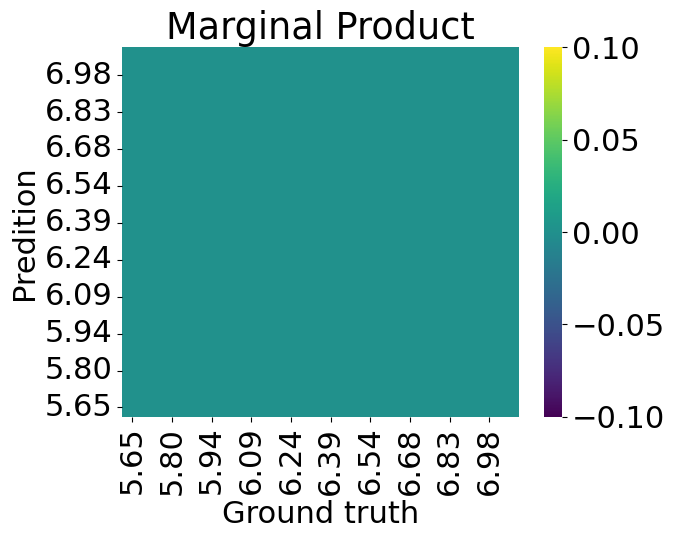

In [96]:
def marginal_product_plot(labels, preds, num_bins=20):
    df_plot = pd.DataFrame({'label': labels, 'pred': preds})
    # Calculation
    N = df_plot.count().iloc[0]
    
    # Cut labels and preds to bins
    df_plot['label'], retbin = pd.cut(df_plot['label'], num_bins, labels=False, retbins=True,include_lowest=False)
    df_plot['pred'] = pd.cut(df_plot['pred'], bins=retbin, labels=False).fillna(-1)
    
    heatmap = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            N_i = len(df_plot[(df_plot['pred']==i)])
            N_j = len(df_plot[(df_plot['label']==j)])
            
            heatmap[i,j] = N_i*N_j/N**2
    heatmap_df = pd.DataFrame(heatmap, columns=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]])
    heatmap_df.index=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]]

    # Plot
    plt.rcParams.update({'font.size': 22})

    ax = sns.heatmap(heatmap_df, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.yticks(rotation=0) 
    ax.invert_yaxis()
    plt.title('Marginal Product')
    plt.ylabel('Predition')
    plt.xlabel('Ground truth')
    plt.show()
    
marginal_product_plot(oof_labels, oof_preds)

### Normalized occurences / Marginal product

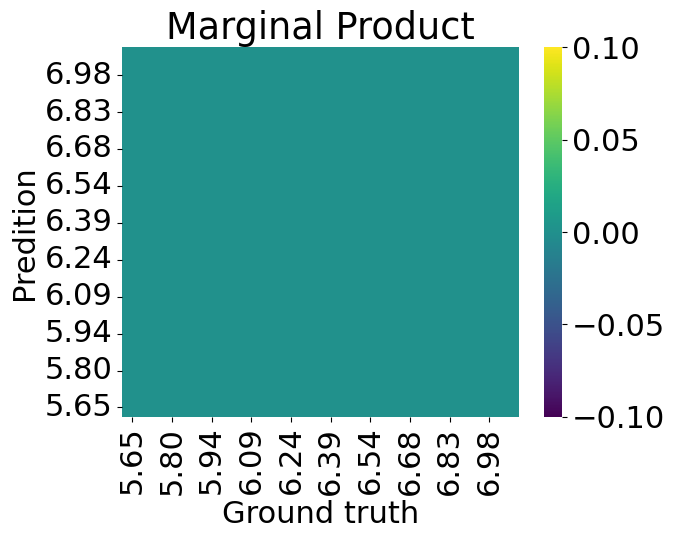

In [97]:
def marginal_product_plot(labels, preds, num_bins=20):
    df_plot = pd.DataFrame({'label': labels, 'pred': preds})
    # Calculation
    N = df_plot.count().iloc[0]
    
    # Cut labels and preds to bins
    df_plot['label'], retbin = pd.cut(df_plot['label'], num_bins, labels=False, retbins=True,include_lowest=False)
    df_plot['pred'] = pd.cut(df_plot['pred'], bins=retbin, labels=False).fillna(-1)
    
    heatmap = np.zeros((num_bins,num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            N_i = len(df_plot[(df_plot['pred']==i)])
            N_j = len(df_plot[(df_plot['label']==j)])
            N_ij = len(df_plot[(df_plot['pred']==i)&(df_plot['label']==j)])
            
            eps = 1
            heatmap[i,j] = N_ij*N / ((N_i+eps) * (N_j+eps))
    heatmap_df = pd.DataFrame(heatmap, columns=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]])
    heatmap_df.index=[str(int(x)) if x.is_integer() else f'{x:.2f}' for x in retbin[:-1]]

    # Plot
    plt.rcParams.update({'font.size': 22})

    ax = sns.heatmap(heatmap_df, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.yticks(rotation=0) 
    ax.invert_yaxis()
    plt.title('Marginal Product')
    plt.ylabel('Predition')
    plt.xlabel('Ground truth')
    plt.show()
    
marginal_product_plot(oof_labels, oof_preds)